# json2db (feedparser) — build SQLite from feed.json

In [2]:

# Config
from pathlib import Path
JSONL_PATH = Path("/Users/wenzheng/Desktop/LLM CS quant/ZZW-LLM/RAGAnalyzer/feed.jsonl")   # path to your line-delimited JSON from the feedparser notebook
DB_PATH = Path("/Users/wenzheng/Desktop/LLM CS quant/ZZW-LLM/RAGAnalyzer/arxiv.db")
print(JSONL_PATH.resolve(), DB_PATH.resolve())


/Users/wenzheng/Desktop/LLM CS quant/ZZW-LLM/RAGAnalyzer/feed.jsonl /Users/wenzheng/Desktop/LLM CS quant/ZZW-LLM/RAGAnalyzer/arxiv.db


In [3]:
# Importer
import json, sqlite3
from datetime import datetime
from typing import Iterable, Dict, Any, Tuple, Optional

#def log(msg: str):
#    print(f"[json2db] {msg}")  #helper for consistent print messages

def split_arxiv_id(raw_id: str):
    # strips URL prefixes like https://arxiv.org/abs/ and .pdf
    # parses trailing vN → returns base id and int version (or None)
    # http://arxiv.org/abs/1234.5678v2 → ("1234.5678", 2)
    s = raw_id.strip()
    for prefix in ("http://arxiv.org/abs/", "https://arxiv.org/abs/", \
                   "http://arxiv.org/pdf/", "https://arxiv.org/pdf/"):
        if s.startswith(prefix):
            s = s[len(prefix):]
            break
    if s.endswith(".pdf"):
        s = s[:-4]
    ver = None
    if "v" in s and s.rsplit("v", 1)[-1].isdigit():
        base, vstr = s.rsplit("v", 1)
        ver = int(vstr)
        return base, ver
    return s, ver

def parse_published(ts: str):
    # robustly parses '2025-03-10T12:34:56Z' or '2025-03-10'
    # returns ('2025-03-10', 2025, 3) ~ iso, y,m
    s = ts.strip()
    for fmt in ("%Y-%m-%dT%H:%M:%SZ", "%Y-%m-%dT%H:%M:%S%z", "%Y-%m-%d"):
        try:
            dt = datetime.strptime(s, fmt)
            iso = dt.strftime("%Y-%m-%d"); return iso, dt.year, dt.month
        except ValueError:
            pass
    iso = s[:10]
    try:
        y,m,_ = [int(x) for x in iso.split("-")]
    except Exception:
        y,m = 0,0
    return iso, y, m


###################################

# Creates/opens the SQLite DB and sets pragmatic PRAGMA options:
def init_db(db_path: Path):
    con = sqlite3.connect(str(db_path))
    con.execute("PRAGMA foreign_keys=ON;")
    cur = con.cursor()
    cur.execute("""
    CREATE TABLE IF NOT EXISTS papers (
        id TEXT PRIMARY KEY,
        arxiv_id TEXT NOT NULL,
        version INTEGER,
        title TEXT NOT NULL,
        summary TEXT,
        published TEXT,
        year INTEGER,
        month INTEGER
    );
    """)
    cur.execute("CREATE UNIQUE INDEX IF NOT EXISTS idx_papers_arxiv_id ON papers(arxiv_id);")
    cur.execute("""
    CREATE TABLE IF NOT EXISTS authors (
        paper_id TEXT NOT NULL,
        position INTEGER NOT NULL,
        author TEXT NOT NULL,
        FOREIGN KEY(paper_id) REFERENCES papers(id) ON DELETE CASCADE
    );
    """)
    cur.execute("""
    CREATE VIRTUAL TABLE IF NOT EXISTS fts_content USING fts5(
        arxiv_id, title, summary, content=''
    );
    """)
    con.commit()
    return con

def upsert_record(con, rec):
    # Extracts fields from one JSON record:
    #   raw_id, title, summary, published, authors[]
    # Normalizes id → (base_id, ver) and published → (iso, year, month)
    # Checks needs_update(); if updating, deletes old row (and its authors)
    # Inserts fresh row into papers, authors, and fts_content
    raw_id = str(rec.get("id","")).strip()
    base_id, ver = split_arxiv_id(raw_id)
    title = str(rec.get("title",""))
    summary = str(rec.get("summary",""))
    published = str(rec.get("published",""))
    authors = rec.get("authors", []) or []
    iso,y,m = parse_published(published)
    cur = con.cursor()
    row = cur.execute("SELECT id, version FROM papers WHERE arxiv_id = ?", (base_id,)).fetchone()
    should = False; old_id = None
    if row is None:
        should = True
    else:
        old_id, old_ver = row
        if ver is not None and (old_ver is None or ver > old_ver):
            should = True
    if not should: 
        return False
    if old_id is not None:
        cur.execute("DELETE FROM authors WHERE paper_id = ?", (old_id,))
        cur.execute("DELETE FROM papers WHERE id = ?", (old_id,))
    cur.execute("""
        INSERT INTO papers (id, arxiv_id, version, title, summary, published, year, month)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """, (raw_id, base_id, ver, title, summary, iso, y, m))
    for pos, name in enumerate(authors):
        cur.execute("INSERT INTO authors (paper_id, position, author) VALUES (?, ?, ?)", (raw_id, pos, str(name).strip()))
    cur.execute("INSERT INTO fts_content (rowid, arxiv_id, title, summary) VALUES ((SELECT rowid FROM papers WHERE id = ?), ?, ?, ?)",
                (raw_id, base_id, title, summary))
    con.commit()
    return True

In [4]:

# Run import
if not JSONL_PATH.exists():
    raise FileNotFoundError(f"JSONL not found at {JSONL_PATH.resolve()}")
con = init_db(DB_PATH)
n_total = 0; n_written = 0
with JSONL_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line: 
            continue
        try:
            rec = json.loads(line)
        except Exception as e:
            print("skip bad line:", e)
            continue
        n_total += 1
        if upsert_record(con, rec):
            n_written += 1
con.close()
print(f"Processed {n_total} records, wrote/updated {n_written}. DB -> {DB_PATH.resolve()}")


Processed 917 records, wrote/updated 917. DB -> /Users/wenzheng/Desktop/LLM CS quant/ZZW-LLM/RAGAnalyzer/arxiv.db


In [6]:

# Quick checks
import sqlite3
con = sqlite3.connect(str(DB_PATH))
print("papers:", con.execute("SELECT COUNT(*) FROM papers").fetchone()[0])
print("authors:", con.execute("SELECT COUNT(*) FROM authors").fetchone()[0])
rows = con.execute("SELECT arxiv_id, title, published FROM papers ORDER BY published DESC LIMIT 5").fetchall()
for r in rows:
    print(r)
con.close()


papers: 917
authors: 5219
('2508.04942', 'Accelerating Conditional Prompt Learning via Masked Image Modeling for\n  Vision-Language Models', '2025-08-07')
('2508.04976', 'CSRAP: Enhanced Canvas Attention Scheduling for Real-Time Mission\n  Critical Perception', '2025-08-07')
('2508.04979', 'Steering One-Step Diffusion Model with Fidelity-Rich Decoder for Fast\n  Image Compression', '2025-08-07')
('2508.04984', 'Propagating Sparse Depth via Depth Foundation Model for\n  Out-of-Distribution Depth Completion', '2025-08-07')
('2508.04987', 'Unified modality separation: A vision-language framework for\n  unsupervised domain adaptation', '2025-08-07')


##  plot 

In [8]:
# --- Plotting helpers (Matplotlib, one chart per cell) ---
import sqlite3
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DB_PATH = Path("/Users/wenzheng/Desktop/LLM CS quant/ZZW-LLM/RAGAnalyzer/arxiv.db")

def _connect(db_path=DB_PATH):
    if not Path(db_path).exists():
        raise FileNotFoundError(f"DB not found: {db_path}. Run the import cell first.")
    con = sqlite3.connect(str(db_path))
    con.execute("PRAGMA foreign_keys=ON;")
    return con

def plot_papers_per_month():
    """
    Line plot: number of papers per (year, month)
    """
    con = _connect()
    q = """
        SELECT printf('%04d-%02d', year, month) AS ym, COUNT(*) AS n
        FROM papers
        WHERE year > 0 AND month > 0
        GROUP BY year, month
        ORDER BY year, month
    """
    df = pd.read_sql_query(q, con)
    con.close()

    if df.empty:
        print("No rows in papers.")
        return

    # Fill gaps in months for a clean time series
    idx = pd.period_range(start=df["ym"].iloc[0], end=df["ym"].iloc[-1], freq="M").astype(str)
    df = df.set_index("ym").reindex(idx, fill_value=0).rename_axis("ym").reset_index()

    plt.figure()
    plt.plot(df["ym"], df["n"])
    plt.title("Papers per Month")
    plt.xlabel("Year-Month")
    plt.ylabel("Count")
    plt.xticks(df["ym"][::max(1, len(df)//12)], rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_top_authors(top_n=20):
    """
    Horizontal bar chart: top N authors by #papers
    """
    con = _connect()
    q = """
        SELECT a.author, COUNT(*) AS n
        FROM authors a
        JOIN papers p ON p.id = a.paper_id
        GROUP BY a.author
        ORDER BY n DESC
        LIMIT ?
    """
    df = pd.read_sql_query(q, con, params=(int(top_n),))
    con.close()

    if df.empty:
        print("No authors found.")
        return

    plt.figure()
    df = df.sort_values("n")  # small->large so barh reads top at the top
    plt.barh(df["author"], df["n"])
    plt.title(f"Top {top_n} Authors")
    plt.xlabel("# Papers")
    plt.ylabel("Author")
    plt.tight_layout()
    plt.show()

def plot_keyword_trend(query, min_month=None, max_month=None):
    """
    Line plot: count of papers matching an FTS query per month.
    Examples:
        plot_keyword_trend("diffusion")
        plot_keyword_trend('"graph neural network" OR GNN')
        plot_keyword_trend('quantum NEAR/2 error')
    """
    con = _connect()
    q = """
        SELECT substr(p.published, 1, 7) AS ym, COUNT(*) AS n
        FROM fts_content f
        JOIN papers p ON p.rowid = f.rowid
        WHERE f.fts_content MATCH ?
        GROUP BY ym
        ORDER BY ym
    """
    df = pd.read_sql_query(q, con, params=(query,))
    con.close()

    if df.empty:
        print(f"No matches for query: {query}")
        return

    # Restrict to a range if provided (format 'YYYY-MM')
    if min_month:
        df = df[df["ym"] >= str(min_month)]
    if max_month:
        df = df[df["ym"] <= str(max_month)]
    if df.empty:
        print("No data in the requested month range.")
        return

    # Fill gaps in months for smooth line
    idx = pd.period_range(start=df["ym"].iloc[0], end=df["ym"].iloc[-1], freq="M").astype(str)
    df = df.set_index("ym").reindex(idx, fill_value=0).rename_axis("ym").reset_index()

    plt.figure()
    plt.plot(df["ym"], df["n"])
    plt.title(f'Keyword trend: {query}')
    plt.xlabel("Year-Month")
    plt.ylabel("# Matching Papers")
    plt.xticks(df["ym"][::max(1, len(df)//12)], rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


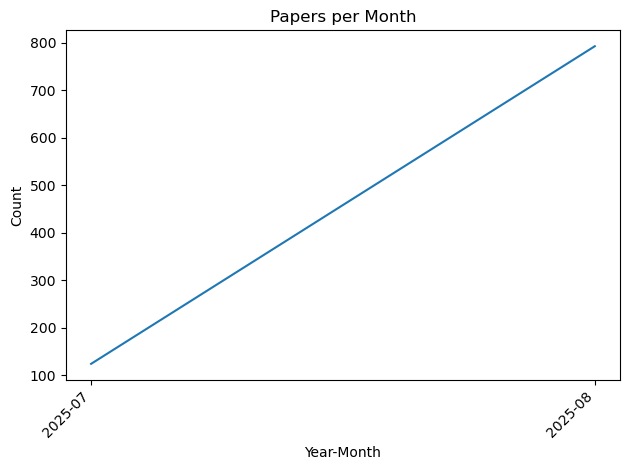

In [9]:
plot_papers_per_month()         # monthly volume

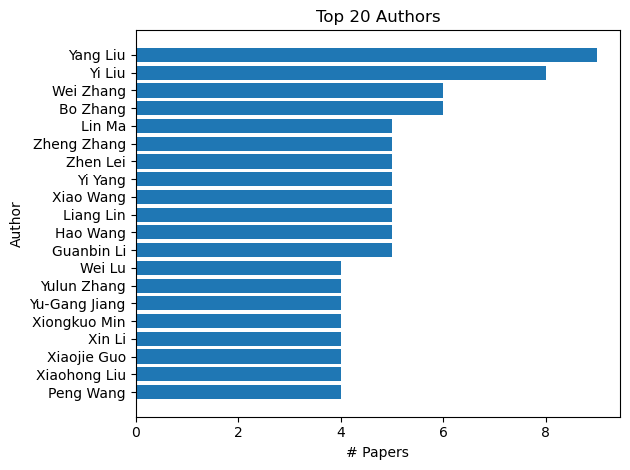

In [10]:
plot_top_authors(20)            # top 20 authors

In [12]:
# plot_keyword_trend("diffusion") # FTS query; supports NEAR, quotes, OR, etc.
# e.g. plot_keyword_trend('quantum NEAR/2 error')
# or   plot_keyword_trend('"graph neural network" OR GNN', min_month="2023-01")
